<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es3/loss_explanation_with_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [219]:
batch_size = 10
features =100
data = 10*np.random.randint(-10,10,size=(batch_size,features))# generate dummy data
data = data/np.expand_dims(np.sqrt((data**2).sum(axis=1)),axis=1)

In [220]:
np.sqrt((data**2).sum(axis=1))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [221]:
data_paired = data + 0*np.random.randn(batch_size,features)# generate fake paired data: zero noise for a "trained" network. High noise for random features

In [222]:
N = 2 * batch_size
mask = np.ones((N, N), dtype=bool)# all ones

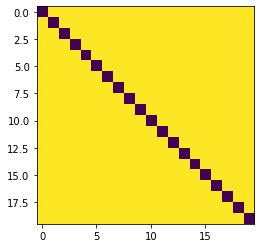

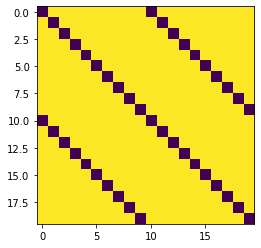

In [223]:
np.fill_diagonal(mask,0)# principal diagona, same element(i,i). They are the same.

plt.figure()
plt.imshow(mask)
for i in range(batch_size):
    mask[i, batch_size + i] = 0# element at batch size distance (paired)
    mask[batch_size + i, i] = 0# element at batch size distance (paired)
plt.figure()
plt.imshow(mask)

In [224]:
N = 2 * batch_size

In [225]:
z = np.concatenate((data, data_paired), axis=0)
print(z.shape)# concatenetad array over batch size

(20, 100)


In [226]:
similarity_f = nn.CosineSimilarity(dim=2)

In [227]:
ztmp = torch.from_numpy(z) # hust to use torch batched version of cosine similarity
print(ztmp.unsqueeze(1).shape)
print(ztmp.unsqueeze(0).shape)

torch.Size([20, 1, 100])
torch.Size([1, 20, 100])


In [228]:
sim = similarity_f(ztmp.unsqueeze(1), ztmp.unsqueeze(0)).numpy()

In [229]:
print(sim.shape)

(20, 20)


Text(0.5, 1.0, 'cosine distance between elemnts')

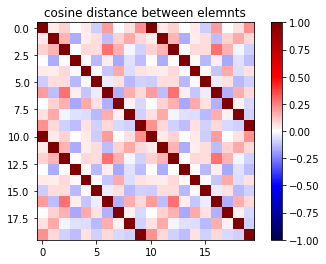

In [230]:
plt.figure()
plt.imshow(sim,cmap="seismic",vmax=1,vmin=-1)
plt.colorbar()
plt.title("cosine distance between elemnts")

In [209]:
sim_i_j = np.diag(sim,batch_size)
sim_j_i = np.diag(sim, -batch_size)

In [210]:
#the are the paired ones!!!!
print(sim_i_j) # upper diagonal (the dark one)
print(sim_j_i) # lower diagonal (the dark one)

[ 0.01762815 -0.09457468 -0.24811125  0.03097416  0.08673849 -0.03295691
 -0.04621197 -0.01792241  0.04543841 -0.06406434]
[ 0.01762815 -0.09457468 -0.24811125  0.03097416  0.08673849 -0.03295691
 -0.04621197 -0.01792241  0.04543841 -0.06406434]


In [211]:
# paired images
positive_samples = np.concatenate((sim_i_j, sim_j_i), axis=0).reshape(N, 1)
print(positive_samples.shape)

(20, 1)


In [212]:
#all others. Using the mask we defined before
negative_samples = sim[mask].reshape(N, -1)
print(negative_samples.shape)

(20, 18)


In [213]:
labels = torch.from_numpy(np.array([0]*N)).reshape(-1).numpy()
labels.shape

(20,)

In [214]:
logits = np.concatenate((positive_samples, negative_samples), axis=1)

In [215]:
logits.shape

(20, 19)

In [216]:
criterion = nn.CrossEntropyLoss(reduction="sum")

In [217]:
criterion(torch.from_numpy(logits), torch.from_numpy(labels)).numpy()/N # loss is low for low noise and high for high noise. Exactly what we wanted!!!!!!


2.982199119917638